<a href="https://colab.research.google.com/github/StillWork/AIDD-2208-add/blob/main/c_85_9_VAE_GenarativeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE를 이용한 생성 모델
- Variational Autoencoder은 오코인코더를 개선하여 평균과 표준편차 두개의 성분을 나타내는 두개의 임베딩 벡터를 생성하게 한다
- 이를 이용하면 더 다양한 출력을 생성할 수 있다
- 새로운 분자의 구조를 생성하는 모델에 적용할 수 있다
- 분자 표현으로 SMILES를 사용하며 새로운 SMILES를 얻는다
 - MolrculeNet이 제공하는 SMILES 데이터셋 MUV 사용 (약 90000개 제공)
 - Maximum Unbiased Validation(MUV) - 17개의 태스크 포함
- [VAE 소개](https://towardsdatascience.com/an-introduction-to-variational-auto-encoders-vaes-803ddfb623df)

In [1]:
!pip install DeepChem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 5.1 MB/s 
     |████████████████████████████████| 29.5 MB 1.3 MB/s 


In [2]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers

import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'retina'

In [3]:
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

# SMILES 문자열의 규칙을 파악: 문자(토큰)의 목록, 문자열의 최대길이 등

tokens = set()
for s in train_smiles:
  tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in train_smiles)

# 모델 만들기
# AspuruGuzikAutoEncoder: 인코더는 합성곱신경망을, 디코더는 순환신경망을 사용
# 학습속도를 조절하기 위해서 ExponentialDecay를 사용한다
# 0.001에서 시작하고 이포크마다 0.95배로 감소시킨다

from deepchem.models.optimizers import ExponentialDecay
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder
batch_size = 100
batches_per_epoch = len(train_smiles)/batch_size
learning_rate = ExponentialDecay(0.001, 0.95, batches_per_epoch)
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='vae', 
                batch_size=batch_size, learning_rate=learning_rate)

# 시퀀스 생성 함수 정의

def generate_sequences(epochs):
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)

# AspuruGuzikAutoEncoder이 제공하는 자체 학습 함수 (이포크수 지정)

model.fit_sequences(generate_sequences(50)) # 50 이포크 수


In [15]:
# 학습된 모델을 이용하여 새로운 분자를 만든다
# 모델에 들어가는 벡터의 크기를 지정한다 (예: 196)
# 벡터를 2000개 생성하겠다
# 생성된 분자들중 유효한 SMILES를 걸러내기 위해서 RDKit의 MolFromSmiles를 사용한다

from rdkit import Chem
predictions = model.predict_from_embeddings(np.random.normal(size=(2000,196)))
molecules = []
for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules.append(smiles)
print()
print('Generated molecules:')
for m in molecules:
  print(m)


Generated molecules:
CC1nncc1
CC(=O)c1nc(C)c2nnc(Cc3nnnn3nc2C)n1
Cc1cnnc(C)nnnnnnnc(NNC)ccnnn1
CC(CO)c1c(Nc2nc(C)n(Cc2cc(C)c2))c(C)cc2n1


In [16]:
molecules

['CC1nncc1',
 'CC(=O)c1nc(C)c2nnc(Cc3nnnn3nc2C)n1',
 'Cc1cnnc(C)nnnnnnnc(NNC)ccnnn1',
 'CC(CO)c1c(Nc2nc(C)n(Cc2cc(C)c2))c(C)cc2n1']

In [28]:
len(predictions)

2000

In [29]:
predictions[0]

['C',
 'C',
 '1',
 'c',
 'c',
 'c',
 '(',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 ')',
 'C',
 ')',
 ')',
 ')',
 'C',
 '(',
 '=',
 'O',
 ')',
 '[',
 'H',
 'O',
 '/',
 '(',
 '=',
 '=',
 '=',
 '=']

## 생성된 SMILES 들에 대해서 유효하지 않거나 약물로서 가치가 없는 분자를 걸러내야 한다
- 제거하고 싶은 분자가 있는지 찾는다
- MolFromSmiles()을 사용해 SMILES 문자열들을 분자 객체로 변환한다
- 분자의 크기를 확인한다 (10보다 작으면 상호작용에 필요한 에너지가 불충분하고, 50 이상이면 분자의 용해도가 너무 낮아 문제가 된다)
- 수소를 제외한 분자의 크기를 GetNumAtoms()로 얻는다
- 약물과 얼마나 유사한지를 판단하기 위해서 QED(Quantitave Estimate of Drugness)를 많이 사용한다
 - QED: 계산된 속성 집합과 판매된 약물의 동일한 특성 분포를 정량화 한 것 (Richard Bickerton 이 제안)
 - 1에 가까울수록 기존의 약물과 유사하다고 본다
 - QED > 0.5 인 분자만 고른 후 결과를 시각화 한다

In [17]:
from rdkit import Chem
molecules_new = [Chem.MolFromSmiles(x) for x in molecules]
print(sorted(x.GetNumAtoms() for x in molecules_new))

[6, 21, 23, 23]


In [18]:
good_mol_list = [x for x in molecules_new if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50]
print(len(good_mol_list))

3


In [31]:
good_mol_list

In [19]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]

In [20]:
qed_list

[0.7463650360502622, 0.5691145103612111, 0.8816928521462161]

In [21]:
final_mol_list = [(a,b) for a,b in zip(good_mol_list, qed_list) if b > 0.5] # 
final_mol_list

[(<rdkit.Chem.rdchem.Mol at 0x7f2ae035bda0>, 0.7463650360502622),
 (<rdkit.Chem.rdchem.Mol at 0x7f2ae035be40>, 0.5691145103612111),
 (<rdkit.Chem.rdchem.Mol at 0x7f2ae035be90>, 0.8816928521462161)]

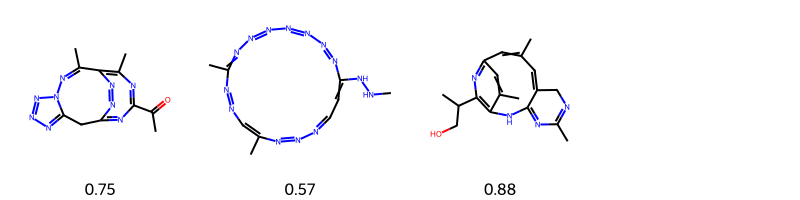

In [32]:
img=Draw.MolsToGridImage([x[0] for x  in final_mol_list],
                         molsPerRow=4,subImgSize=(200,200),
                         legends=[f"{x[1]:.2f}" for x in final_mol_list])
img

# 모델 restore()

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
model_2 = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='/content/drive/MyDrive/vae', 
                batch_size=batch_size, learning_rate=learning_rate)
model_2.restore()

In [47]:
predictions_2 = model_2.predict_from_embeddings(np.random.normal(size=(10,196)))
molecules_2 = []
for p in predictions_2:
  smiles = ''.join(p)
  # if Chem.MolFromSmiles(smiles) is not None:
  molecules_2.append(smiles)

molecules_2

['C1(=O)N11Fcccn((OC(F)nc2nc2c2c(c(())(Fn',
 'c1cc((C)(CNc2n(c3cc((c3nncnnnnc22',
 'CC11(=C)nnn2(N)nn((C)c2())c2nnc((C)n1',
 'Cc1cc2c2cc2cc2ccccccc2)ccccccccccc12',
 'cc1cc22nc())c(C)nc(CC)n3nn())c(C)n',
 'CC1ccCc22nccccccccc)))ccccCC)c2))CCC))22',
 'CcCCc2nc(=O)n(CCc3nnnc()n(C)c3nc(=O)n1',
 'O11Cnnnnnnn11)C1C)FFcccccnnncnc2cccc2ccc1',
 'c1cc((C22222nC)2)nn))))c2nnc3cccc2())C',
 'OC1Cc2ncccccCO)cc1CNNCC))ccC)))']